# Background about the data

I have generated three incremental circular buffers around each [known PurpleAir's sensors](http://map.pscleanair.org/) in Seattle, with the respective range of 1000 m (red), 3000 m (orange), and 6000 m (green). These three groups are indicated by the <b>"mrb_dist"</b> field. I then intersected those buffers with a Census Blocks layer containing data about different age and race groups.

![buffers](forJ_img/census_intersected_purpleAirRange.PNG)

ps: Note that, for example, 1000 m refers to the radius of the buffer.

Now, the thing to keep in mind about each of those buffers is that they *do not* overlap. See below (orange point represents a sensor's location):

![buffers](forJ_img/buff1.PNG)
* Communities that live within 1,000 m for a PurpleAir's sensor;

![buffers](forJ_img/buff2.PNG)
* Communities that live further than 1,000 m away, and not further than 3,000 m;

![buffers](forJ_img/buff3.PNG)
* Communities that live further than 3,000 m away from a sensor, and not further than 6,000 m.


<b>Why did I do this?</b>
    I thought that this may highlight similarities/differences between groups based on proximity to a sensor. If you have reservations about my thought-process, please let me know.

## Making a necessary adjustment to the Blocks at the boundaries of incremental buffers

An issue that is not immediately apparent but can cause a loss of precision in the subsequent analysis is this:
![](forJ_img/error.PNG)


The polygon highlighted overlaps the boundary between two buffers. If the data was a raster, made of pixels, this wouldn't be an issue: the value would be aggregated to the total number of pixels within its respective boundaries.

However, this is a vector dataset. Thus, the entire polygon, regardless of how large it is, retains the same value. Thus, what is happening above, where the Census Block polygon is intersected by the boundaries of the buffer, is replicating the data twice between buffers.

That kind of error isn't the biggest of deals, but we do want to try to retain our analysis as accurate as possible.

Therefore, not really recalling the stuff I could do in QGIS to rectify this, I calculated the area for each feature in the dataset (in m squared). The goal? Remove all duplicates of Blocks which have been intersected using a criteria: if the area of the duplicated feature is smaller than the other, it gets removed.

***
![](forJ_img/validating_area.PNG)
*Pro-tip: Confirm if generated outputs seem weird. I wasn't 100% confident about the values generated for area; using the [Vector > Analysis Tools > Basic Statistic for Fields] tool, I found the sum of area for all of my Census Tracts, an output reasonably close according to Google:*

![](forJ_img/google.png)
*(It's not exactly equal because a couple of Blocks were dropped since there were breaks in the Census' geometry...but these Blocks weren't situated in residential areas so it's fine to omit them...if you thought data cleaning was bad before welcome to my world fml).*
***

This way, we don't get a tiny intersected segment having an outsized effect when you'll be doing your group-by's aggregations'.

Note: thinking as a spatial analyst, this is far from an "ideal" option, since polygons don't represent density of data, but an abstraction tied to a delineated unit. But why not convert the vector to a raster you might say? If we were dealing with one feature only, say population density, sure! And we could figure out some type of normalization ad hoc. But we've like, dozens of features at least, and converting each of those features into their respective raster representation would be time consuming and a huge hassle. For our purposes, this is an absolutely appropriate method to rectify noise in our dataset. Yes I'm writing all of this down so 1) I don't forget and 2) to convince myself that I am not totally clueless.

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import geopandas as gpd  # You might need to install geopandas
import pandas as pd
import glob # You might need to install glob

## Importing the stuff

In [4]:
d = {}  # dictionary that will hold them 

#C:\Users\johna\Desktop\forJ\forJohnathan_SummarizingDemographicVariablesWithinPurpleAirMonitorZoneOfCoverage.ipynb

# glob allows you to batch import multiple files...I mean I'm only importing one file here...for future reference
files = glob.glob('./forJ_data/*.geojson') 
display(files)

for file in files:
    file_name = file.split('.')[1].split('\\')[2]
    d[file_name] = gpd.read_file(file)
    print(file_name)
    print(type(d[file_name]))

['./forJ_data\\CensusTracts_Union_RedLined.geojson',
 './forJ_data\\forPandas_censusBlocks_validated_intersectedwithPurpleAirBuffers_areaCalculated.geojson']

IndexError: list index out of range

In [3]:
files = glob.glob('./forJ_data/*.geojson') 
df_holc = gpd.read_file(files[0])

In [201]:
4.548/len(length)

0.2675294117647059

In [ ]:
Asthm = {'A':0.52, 'B':0.22, 'C':0.40, 'D':0.27}

In [4]:
# Data is stored in a dictionary, just save it to a dataframe
df = gpd.read_file(files[1])

display(df.size) 
display(df.columns)

col = ['Total_Population',
       'Female_under_5_years', 'Male_under_5_years',
       'Female_Person_of_Color_5_17_years', 'Male_Person_of_Color_5_17_years',
       'Female_White_5_17_years', 'Male_White_5_17_years',
       'Female_Age_65_and_over', 'Male_Age_65_and_over',
       'Population_Hispanic_or_Latino', 'Pop_Not_Hispanic_White_alone',
       'Pop_Not_Hispanic_Black_or_African_American_alone',
       'Pop_Not_Hispanic_American_Indian_and_Alaska_Native_alone',
       'Pop_Not_Hispanic_Asian_alone',
       'Pop_Not_Hispanic_Native_Hawaiian_and_Oth_Pacific_Islander_alone',
       'Pop_Not_Hispanic_Some_Other_Race_alone',
       'Pop_Not_Hispanic_Two_or_More_Races']
df[col] = df[col].astype(int)

# for the age group variables, you'll have to convert from obj to int :(
                           # mrb_dist is the field that indicated the "level" of the buffer
                                # area_intersect is area in m squared per polygons.

display(df.dtypes)     
print('conversion tip: https://stackoverflow.com/questions/39173813/pandas-convert-dtype-object-to-int')
df.head(3)

291600

Index(['OBJECTID', 'GEOID10', 'GEO_TYPE', 'TRACT_10', 'Total_Population',
       'Female_under_5_years', 'Male_under_5_years',
       'Female_Person_of_Color_5_17_years', 'Male_Person_of_Color_5_17_years',
       'Female_White_5_17_years', 'Male_White_5_17_years',
       'Female_Age_65_and_over', 'Male_Age_65_and_over',
       'Population_Hispanic_or_Latino', 'Pop_Not_Hispanic_White_alone',
       'Pop_Not_Hispanic_Black_or_African_American_alone',
       'Pop_Not_Hispanic_American_Indian_and_Alaska_Native_alone',
       'Pop_Not_Hispanic_Asian_alone',
       'Pop_Not_Hispanic_Native_Hawaiian_and_Oth_Pacific_Islander_alone',
       'Pop_Not_Hispanic_Some_Other_Race_alone',
       'Pop_Not_Hispanic_Two_or_More_Races', 'mrb_dist', 'area_intersect',
       'geometry'],
      dtype='object')

OBJECTID                                                              int64
GEOID10                                                              object
GEO_TYPE                                                             object
TRACT_10                                                             object
Total_Population                                                      int64
Female_under_5_years                                                  int64
Male_under_5_years                                                    int64
Female_Person_of_Color_5_17_years                                     int64
Male_Person_of_Color_5_17_years                                       int64
Female_White_5_17_years                                               int64
Male_White_5_17_years                                                 int64
Female_Age_65_and_over                                                int64
Male_Age_65_and_over                                                  int64
Population_H

conversion tip: https://stackoverflow.com/questions/39173813/pandas-convert-dtype-object-to-int


,OBJECTID,GEOID10,GEO_TYPE,TRACT_10,Total_Population,Female_under_5_years,Male_under_5_years,Female_Person_of_Color_5_17_years,Male_Person_of_Color_5_17_years,Female_White_5_17_years,...,Pop_Not_Hispanic_White_alone,Pop_Not_Hispanic_Black_or_African_American_alone,Pop_Not_Hispanic_American_Indian_and_Alaska_Native_alone,Pop_Not_Hispanic_Asian_alone,Pop_Not_Hispanic_Native_Hawaiian_and_Oth_Pacific_Islander_alone,Pop_Not_Hispanic_Some_Other_Race_alone,Pop_Not_Hispanic_Two_or_More_Races,mrb_dist,area_intersect,geometry
0,1,530330067001001,Block,6700,38,0,0,0,0,0,...,30,0,0,2,0,1,3,3000,121037.5710,"MULTIPOLYGON (((549534.375 5275664.786, 549554..."
1,2,530330069001009,Block,6900,90,4,5,2,2,7,...,76,0,1,4,0,0,3,1000,20396.5916,"MULTIPOLYGON (((547901.800 5276034.136, 547801..."
2,3,530330116003013,Block,11600,67,1,0,1,3,4,...,60,0,0,1,0,0,1,6000,23669.5757,"MULTIPOLYGON (((546330.740 5263601.521, 546329..."


## All I do is clean

In [7]:
# GEOID10 is the unique Block id
    # area_intersect is the area of intersected features
        # we want to retain all of the unique GEOID10 which have the greatest area_intersect value

# Let's see how many duplicates we have:
len(df['GEOID10'])-len(df['GEOID10'].drop_duplicates())

1115

In [5]:
# The solution I found is...easy: https://stackoverflow.com/questions/12497402/python-pandas-remove-duplicates-by-columns-a-keeping-the-row-with-the-highest
        # Sort area_intersect from descending values (low to high), and retain 'last', i.e. the ascending value.
        
df = df.sort_values('area_intersect', ascending=False).drop_duplicates('GEOID10').sort_index()

In [9]:
# No more duplicates!
len(df['GEOID10'])-len(df['GEOID10'].drop_duplicates())

0

# Red-Lining Intersection Analysis

Here, instead of intersection Census Blocks with the PurpleAir's Buffer, I have *unioned* the Census Tracts with the borders of the HOLC Grading map.

This enables us to see how a number of variables differ between different zoning grades; areas where holc_grade is NULL means that these areas where not included in the HOLC map (as an added reference of comparison).

![](forJ_img/holc.PNG)

In [204]:
# Data is stored in a dictionary, just save it to a dataframe


#display(df_holc.shape)  # for the age group variables, you'll have to convert from obj to int :(
                            # mrb_dist is the field that indicated the "level" of the buffer
                                # area_intersect is area in m squared per polygons.
print('conversion tip: https://stackoverflow.com/questions/39173813/pandas-convert-dtype-object-to-int')
#'Male_under_5_years','Female_Person_of_Color_5_17_years','Male_Person_of_Color_5_17_years','Female_White_5_17_years','Male_White_5_17_years','Female_Age_65_and_over','Male_Age_65_and_over'
#df_holc.dropna()
df_holc['Female_under_5_years'].astype(int)
#display(df_holc.dtypes)
df_holc.head(3)

conversion tip: https://stackoverflow.com/questions/39173813/pandas-convert-dtype-object-to-int


,OBJECTID,GEOID10,NAMELSAD10,PCT_PEOPLE_OF_COLOR,PTL_PEOPLE_OF_COLOR,PCT_ENGLISH_LESSTHAN_VERY_WELL,PTL_ENGLISH_LESSTHAN_VERY_WELL,PCT_FOREIGN_BORN,PTL_FOREIGN_BORN,PCT_POP_INC_UNDER_200_POVERTY,...,Male_White_5_17_years,Female_Age_65_and_over,Male_Age_65_and_over,holc_id,holc_grade,area_description_data,area_holc,area_union,area_pct,geometry
0,1.0,53033005900,Census Tract 59,0.184537,0.241,0.013041,0.098,0.095335,0.241,0.195256,...,224,199,240,B11,B,"{'1': 'This is the ""Queen Anne Hill"" district ...",3.878858e+06,792517.1533,20.4317,"MULTIPOLYGON (((548001.150 5276862.448, 548001..."
1,1.0,53033005900,Census Tract 59,0.184537,0.241,0.013041,0.098,0.095335,0.241,0.195256,...,224,199,240,C8,C,{'1': 'This district located on a steep side h...,1.178363e+06,413543.6118,35.0947,"MULTIPOLYGON (((547052.434 5276555.074, 547047..."
2,1.0,53033005900,Census Tract 59,0.184537,0.241,0.013041,0.098,0.095335,0.241,0.195256,...,224,199,240,C9,C,{'1': 'A blighted area with old homes generall...,2.961728e+05,124931.0107,42.1818,"MULTIPOLYGON (((547997.260 5277533.225, 547997..."


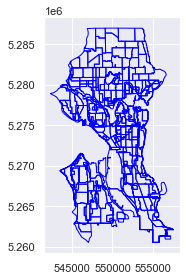

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_holc.plot(ax=ax, facecolor='none', edgecolor='blue');

plt.tight_layout();

## Wrangling duplicates:

Now, similar to the issue of duplication with buffer boundaries, we want to drop duplicates at the boundaries of the zoning map. I am taking one extra step: 

* I calculated the area (m^2) for each HOLC zones.
* Once I unioned both layers, which created new polygons due to the HOLC boundaries, I re-calculated the area for all features.
* Wanting to retain the Tract whose area "falls the most" within the area of the HOLC zone (remember, a single Census Tract may overlap several HOLC zones), to avoid duplication of data, I dropped all duplicates, retaining the feature that is proportionally the largest within the HOLC boundary (area_pct = area of unioned polygons / area of HOLC). 

## Here we drop the duplicate features created when I unioned both layers

In [22]:
len(df_holc['NAMELSAD10'])-len(df_holc['NAMELSAD10'].drop_duplicates()) # Census Tract Duplicates  

263

In [6]:
df_holc1 = df_holc.sort_values('area_union', ascending=False).drop_duplicates('GEOID10').sort_index()

# df_holc1 = df_holc1[(~df_holc1['GEOID10'].duplicated()) | df_holc1['area_pct'].isna()]

### Observe the change due to dropping duplicate features.

In [24]:
display(df_holc1.shape) 
len(df_holc1['NAMELSAD10'])-len(df_holc1['NAMELSAD10'].drop_duplicates())

(135, 53)

0

In [7]:
asthma = df_holc1[['PCT_ADULT_WITH_ASTHMA', 'holc_grade']]
asthma = asthma.groupby('holc_grade').mean()
asthma = asthma.reset_index()
asthma

,holc_grade,PCT_ADULT_WITH_ASTHMA
0,A,0.081500
1,B,0.087675
2,C,0.091800
3,D,0.094471


In [14]:
df_holc1.head()

,OBJECTID,GEOID10,NAMELSAD10,PCT_PEOPLE_OF_COLOR,PTL_PEOPLE_OF_COLOR,PCT_ENGLISH_LESSTHAN_VERY_WELL,PTL_ENGLISH_LESSTHAN_VERY_WELL,PCT_FOREIGN_BORN,PTL_FOREIGN_BORN,PCT_POP_INC_UNDER_200_POVERTY,...,Male_White_5_17_years,Female_Age_65_and_over,Male_Age_65_and_over,holc_id,holc_grade,area_description_data,area_holc,area_union,area_pct,geometry
0,1.0,53033005900,Census Tract 59,0.184537,0.241,0.013041,0.098,0.095335,0.241,0.195256,...,224,199,240,B11,B,"{'1': 'This is the ""Queen Anne Hill"" district ...",3.878858e+06,7.925172e+05,20.4317,"MULTIPOLYGON (((548001.150 5276862.448, 548001..."
7,5.0,53033004100,Census Tract 41,0.164442,0.158,0.045527,0.519,0.150340,0.549,0.118621,...,616,592,555,A3,A,{'1': 'This area is one of the most popular re...,1.083601e+06,1.066311e+06,98.4044,"MULTIPOLYGON (((553577.135 5278365.104, 553579..."
11,6.0,53033005000,Census Tract 50,0.190026,0.256,0.030799,0.361,0.113123,0.346,0.207874,...,94,79,189,B3,B,"{'1': 'This area is known as the Wallingford"",...",6.844266e+06,7.568218e+05,11.0578,"MULTIPOLYGON (((549820.348 5279284.597, 549820..."
12,7.0,53033004302,Census Tract 43.02,0.428609,0.737,0.168306,0.828,0.327636,0.880,0.651979,...,3,11,151,B4,B,"{'1': 'This is the ""University"" district. Home...",8.290899e+05,2.290753e+05,27.6297,"MULTIPOLYGON (((552416.863 5278886.610, 552414..."
15,9.0,53033007500,Census Tract 75,0.290809,0.519,0.039026,0.459,0.134555,0.474,0.263000,...,35,26,180,C11,C,"{'1': 'This is a ""Twilight"" zone.'}",1.938776e+06,5.785943e+05,29.8433,"MULTIPOLYGON (((551039.454 5273833.807, 551038..."


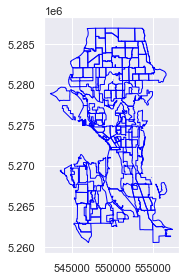

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_holc1.plot(ax=ax, facecolor='none', edgecolor='blue');

plt.tight_layout();

It looks a bit weird if you compare it to the base layer of the U.S. Census Tract (image below), but remember: the Tracts were chopped by the boundaries of the HOLC, so they did not retain their original shape. What we do retain is the original number of Tracts, so that the data for each Tract is represented only once.

![](forJ_img/censusTracts.PNG)

# Data Visualization/Summary time

I really felt like I had to clean-up my mess...

<b>Important</b>: You are working with population counts only, so keep that in mind. There's a column that has the total population for the Census Block; you could always use that as a means to normalize the data. I'll let you handle how to represent the demographic profile for the groups above.

Now, a thing you might think to yourself: "that's it? What gives? Where are income groups, educational attainment etc etc" 
Take those complaints to the U.S. Census Bureau. They only have Block-level data for a limited number of variables for the 2010 Census. I could have used a Block-group from a survey, but trust me when I say: "they don't make it easy to get data from their piece of shtz website".

I also sincerely think that this is well enough for our purposes. Below are relevant stats as to why these groups are included here. 

Plus we have some additional variables at the U.S. Census Tract level that we'll use for the profile of the Red-line districts.

### Demographic trends and air pollution (references in forJ_refs folder)

* US Census Blocks	Race & Age	Male, PoC, 5-17 years "8.45 % (WA average of all non-white groups from 140-185-AsthmaBRFSSdata.pdf p. 4) King County: 8,5 % (average for all non-white groups from Appendix-Chronic-Illness.pdf p. 10)" "Black children have the higest percentage of asthma (12%) compared to other racial groups.

* US Census Blocks	Race & Age	Female, PoC, 5-17 years "8.45 % (WA average of all non-white groups from 140-185-AsthmaBRFSSdata.pdf p. 4) King County: 8,5 % (average for all non-white groups from Appendix-Chronic-Illness.pdf p. 10)" "Black children have the higest percentage of asthma (12%) compared to other racial groups.

* US Census Blocks	Race & Age	Male, White, 5-17 years "6.2 % (WA Avg 140-185-AsthmaBRFSSdata.pdf p. 4) King County: 6% (whites only from Appendix-Chronic-Illness.pdf p. 10)"

* US Census Blocks	Race & Age	Female, White, 5-17 years "6.2 % (WA Avg 140-185-AsthmaBRFSSdata.pdf p. 4) King County: 6% (whites only from Appendix-Chronic-Illness.pdf p. 10)"

* US Census Blocks	Race & Age	Male under 5 years, Hospitalization due to asthma per 100K: 261 (345-304-AsthmaInWashingtonState.pdf p. 3) "Children younger than 5 account for a fifth of the hospitalizations for asthma in the state, with boys more likely to be hospitalized than girls."

* US Census Blocks	Race & Age	Females under 5 years, Hospitalization due to asthma per 100K: 151 (345-304-AsthmaInWashingtonState.pdf p. 3)

* US Census Blocks	Race & Age	Male above 65 years, Hospitalization due to asthma per 100K: 57 (345-304-AsthmaInWashingtonState.pdf p. 3)

* US Census Blocks	Race & Age	Females above 65 years, Hospitalization due to asthma per 100K: 122 (345-304-AsthmaInWashingtonState.pdf p. 3)

* US Census Tract	Race & Age	Persons of color (% of Census tract Pop) "11.01 % (WA average of all non-white groups from 140-185-AsthmaBRFSSdata.pdf p. 4) King County: 9.6 % (average of all non-white groups from Appendix-Chronic-Illness.pdf  p. 2)"	Washington state	https://data.seattle.gov/Land-Base/Racial-and-Social-Equity-Composite-Index/q9y2-kzsi	"In Washington state, non-Hispanic American Indian and Alaska Native adults, and black children report higher asthma rates than other racial or ethnic groups. Asian, white, and Hispanic adults and children report lower asthma rates than other groups."

* US Census Blocks	Race & Age	White Population Density "10.2% WA avg (140-185-AsthmaBRFSSdata.pdf p. 4) King County: 10 % (average of all non-white groups from Appendix-Chronic-Illness.pdf  p. 2)"

* US Census Blocks	Race & Age	Black Population Density "10.8% WA avg (140-185-AsthmaBRFSSdata.pdf p. 4)	

* US Census Blocks	Race & Age	Latino Population Density 7.2% WA avg (140-185-AsthmaBRFSSdata.pdf p. 4)	

* US Census Blocks	Race & Age	Native American Population Density 17% WA avg (140-185-AsthmaBRFSSdata.pdf p. 4)

* US Census Blocks	Race & Age	Asian Population Density 4.5% WA avg (140-185-AsthmaBRFSSdata.pdf p. 4)

In [ ]:
# Your goal is to create demographic profiles for each buffer level, 
# and create one or many visualizations to show trends. 

# Now: what if there is really no discernable trends? It's really seems to be all randomly distributed?
    # That's a fair point to notice and an insight in itself.
        # I can always add a smaller buffer (that's something I can do under 5 min.)

### Red-Lining Trends

Same concept, except you're comparing between HOLC graded areas; you can reuse the same demographic data grouped at the Census Tract level, in addition to variables from the [Racial and Social Equity Composite Index](https://data.seattle.gov/Land-Base/Racial-and-Social-Equity-Composite-Index/q9y2-kzsi) like percentage of adults affected with asthma, poverty level etc.

In [8]:
# get the frames
test = df.groupby(['mrb_dist']).sum()

In [14]:
test= test.reset_index()
test = test.rename(columns = {'Pop_Not_Hispanic_Native_Hawaiian_and_Oth_Pacific_Islander_alone':'Native_Hawaiian\Pacific_Islander','Pop_Not_Hispanic_American_Indian_and_Alaska_Native_alone':'American_Indian/Alaska_Native','Population_Hispanic_or_Latino':'Hispanic/Latino', 'Pop_Not_Hispanic_Black_or_African_American_alone':'Black/African_American', 'Pop_Not_Hispanic_Asian_alone':'Asian', 'Pop_Not_Hispanic_White_alone':'White'})

In [16]:
foo = test[['mrb_dist','Hispanic/Latino','White', 'Black/African_American', 'American_Indian/Alaska_Native', 'Asian', 'Native_Hawaiian\Pacific_Islander' ]]
foo = foo[['Hispanic/Latino','White', 'Black/African_American', 'American_Indian/Alaska_Native', 'Asian', 'Native_Hawaiian\Pacific_Islander']].apply(lambda x: x/602389.0)
foo['mrb_dist'] = ['1000', '2000', '3000']
foo

,Hispanic/Latino,White,Black/African_American,American_Indian/Alaska_Native,Asian,Native_Hawaiian\Pacific_Islander,mrb_dist
0,0.013227,0.198795,0.012630,0.001484,0.020970,0.000488,1000
1,0.034340,0.341577,0.042192,0.003245,0.080853,0.001957,2000
2,0.018706,0.124093,0.021823,0.001658,0.034871,0.001209,3000


In [17]:
# the following are sums of the miniority populations for each buffer zone
mrb_1000 = 0.013227+0.012630+0.001484+0.020970+0.000488
mrb_3000 = 0.034340+0.042192+0.003245+0.080853+0.001957
mrb_6000 = 0.018706+0.021823+0.001658+0.034871+0.001209
lists = [mrb_1000,mrb_3000,mrb_6000]
lists2 = [1000,3000,6000]

In [19]:
Tot_minori = pd.DataFrame()
Tot_minori['mrb_dist'] = lists2
Tot_minori['People of Color'] = lists
Tot_minori['White'] = foo['White']
Tot_minori

,mrb_dist,People of Color,White
0,1000,0.048799,0.198795
1,3000,0.162587,0.341577
2,6000,0.078267,0.124093


In [47]:
foo['mrb_dist'] = Tot_minori['mrb_dist']
foo

,Hispanic/Latino,White,Black/African_American,American_Indian/Alaska_Native,Asian,Native_Hawaiian\Pacific_Islander,mrb_dist
0,0.013227,0.198795,0.012630,0.001484,0.020970,0.000488,1000
1,0.034340,0.341577,0.042192,0.003245,0.080853,0.001957,3000
2,0.018706,0.124093,0.021823,0.001658,0.034871,0.001209,6000


Text(0.5, 1.0, 'Demographic Profile for each Buffer Zone')

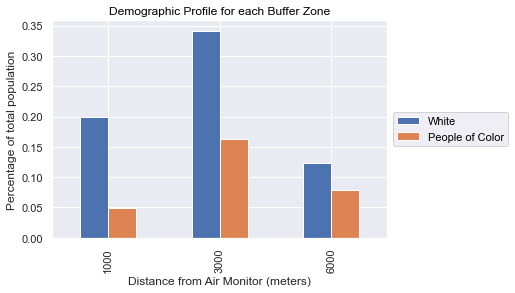

In [38]:
Tot_minori.plot(x='mrb_dist', y=['White','People of Color'], kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Distance from Air Monitor (meters)')
plt.ylabel('Percentage of total population')
plt.title('Demographic Profile for each Buffer Zone')

Text(0.5, 1.0, 'Demographic Profile for each Buffer Zone')

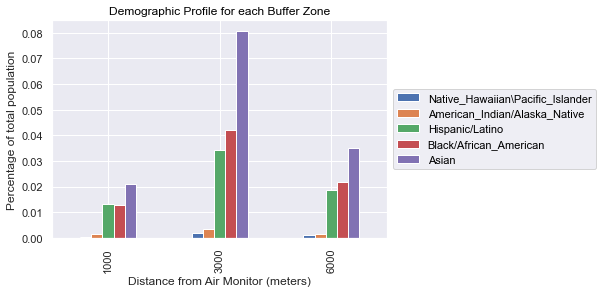

In [48]:
foo.plot(x='mrb_dist', y=["Native_Hawaiian\Pacific_Islander","American_Indian/Alaska_Native","Hispanic/Latino", "Black/African_American",'Asian' ], kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Distance from Air Monitor (meters)')
plt.ylabel('Percentage of total population')
plt.title('Demographic Profile for each Buffer Zone')

In [10]:
test1 = df_holc1.groupby(['holc_grade']).mean()

In [11]:
test1 = test1.reset_index()

Text(0, 0.5, 'Percent (Average)')

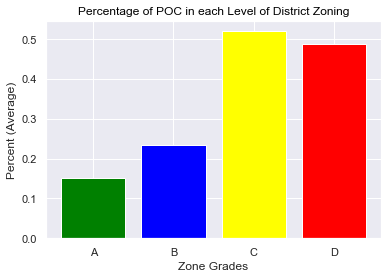

In [55]:
plt.bar(test1['holc_grade'] ,test1['PCT_PEOPLE_OF_COLOR'], color=['green', 'blue', 'yellow', 'red'])
plt.title('Percentage of POC in each Level of District Zoning')
plt.xlabel('Zone Grades')
plt.ylabel('Percent (Average)')

Text(0, 0.5, 'Percentile (Average)')

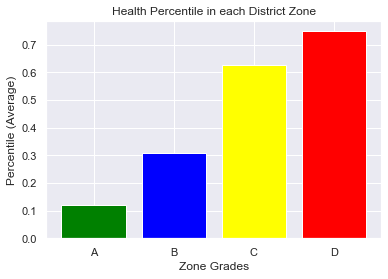

In [18]:
plt.bar(test1['holc_grade'] ,test1['HEALTH_PERCENTILE'], color=['green', 'blue', 'yellow', 'red'])
plt.title('Health Percentile in each District Zone')
plt.xlabel('Zone Grades')
plt.ylabel('Percentile (Average)')

In [19]:
# higher percentage means more disadvantaged 

test1['PCT_POP_INC_UNDER_200_POVERTY'].mean()
test1.groupby(['holc_grade'])['HEALTH_PERCENTILE'].mean()

holc_grade
A    0.120750
B    0.309525
C    0.626050
D    0.749294
Name: HEALTH_PERCENTILE, dtype: float64

Text(0, 0.5, 'Percent (Average)')

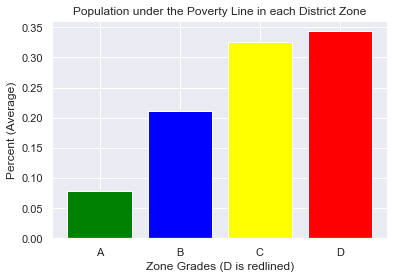

In [12]:
plt.bar(test1['holc_grade'] ,test1['PCT_POP_INC_UNDER_200_POVERTY'], color=['green', 'blue', 'yellow', 'red'])
plt.title('Population under the Poverty Line in each District Zone')
plt.xlabel('Zone Grades (D is redlined)')
plt.ylabel('Percent (Average)')

Text(0, 0.5, 'Percent (Average)')

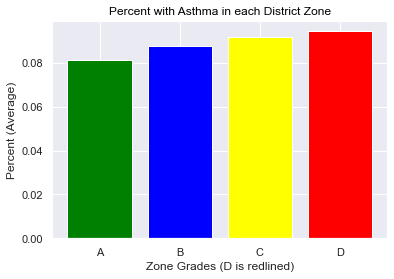

In [58]:
plt.bar(test1['holc_grade'] ,test1['PCT_ADULT_WITH_ASTHMA'], color=['green', 'blue', 'yellow', 'red'])
plt.title('Percent with Asthma in each District Zone')
plt.xlabel('Zone Grades (D is redlined)')
plt.ylabel('Percent (Average)')

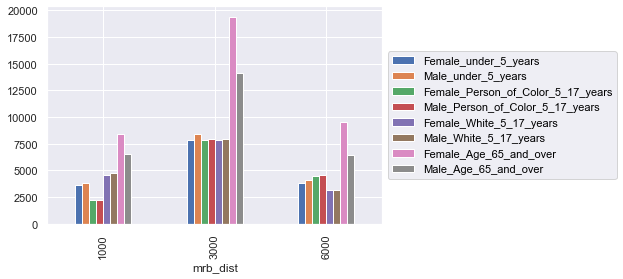

In [63]:
test.plot(x = 'mrb_dist', y = ['Female_under_5_years','Male_under_5_years','Female_Person_of_Color_5_17_years','Male_Person_of_Color_5_17_years','Female_White_5_17_years','Male_White_5_17_years','Female_Age_65_and_over','Male_Age_65_and_over'], kind = 'bar')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))